In [ ]:
#Import Package

#numpy dan pandas digunakan untuk mendapatkan data gambar ke dlm bingkai data
import numpy as np
import pandas as pd

#untuk bekerja dengan data
from pathlib import Path
import os.path

#membuat plot
import plotly.express as px

#untuk pra pemrosesan
from sklearn.model_selection import train_test_split

#confussion matriks dan classification report
from sklearn.metrics import confusion_matrix, classification_report

#pembuatan model
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [ ]:
#Import dan Memasukkan Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Memanggil dataset
image_dir = Path('/content/drive/My Drive/data_ISIC4')

In [ ]:
image_dir

PosixPath('/content/drive/My Drive/data_ISIC4')

##Creating File DataFrame

In [ ]:
## Get filepaths and labels secara terpisah
filepaths = list(image_dir.glob(r'**/*.[jJ][pP][gG]'))

In [ ]:
#filepaths

In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
#fungsi os.path.split untuk membagi nama file dari sisa jalur
#memberi indeks [0] untuk menghilangkan nama file yang seperti 1.jpg
#kemudian untuk mengambil nama label dari nama folder maka gunakan os.path.split lagi
#kemudian diberi indeks [1] untuk hanya mengambil nama label saja.

In [ ]:
#labels

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Sample
samples = []

for category in image_df['Label'].unique():
    category_slice = image_df.query("Label == @category")
    samples.append(category_slice.sample(300, random_state=1))

image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [ ]:
image_df

Filepath      Label
0    /content/drive/My Drive/data_ISIC4/malignant/(...  malignant
1    /content/drive/My Drive/data_ISIC4/malignant/(...  malignant
2    /content/drive/My Drive/data_ISIC4/malignant/(...  malignant
3    /content/drive/My Drive/data_ISIC4/malignant/(...  malignant
4    /content/drive/My Drive/data_ISIC4/benign/(603...     benign
..                                                 ...        ...
895  /content/drive/My Drive/data_ISIC4/malignant/(...  malignant
896  /content/drive/My Drive/data_ISIC4/malignant/(...  malignant
897  /content/drive/My Drive/data_ISIC4/Non_tumor/b...  Non_tumor
898  /content/drive/My Drive/data_ISIC4/Non_tumor/p...  Non_tumor
899  /content/drive/My Drive/data_ISIC4/Non_tumor/b...  Non_tumor

[900 rows x 2 columns]

In [ ]:
#menghitung jumlah setiap kelas
image_df['Label'].value_counts()

malignant    300
benign       300
Non_tumor    300
Name: Label, dtype: int64

In [ ]:
#membagi train dan test dengan sklearn, menentukan ukuran data train 80% dengan pengacakan (shuffle)
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

##Loading the Images

In [ ]:
#generator data gambar dengan menggunakan model mobilenetv2 dengan kumpulan data imagenet

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 648 validated image filenames belonging to 3 classes.
Found 72 validated image filenames belonging to 3 classes.
Found 180 validated image filenames belonging to 3 classes.


##Load Pretrained Model

atau Downloading the Feature Extractor

In [ ]:
#Feature Extractor
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


##Training

In [ ]:
#tambahkan layer klasifikasi baru
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x) #input

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

#mengkompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            #kembalikan bobot epoch terbaik
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
11/11 [==============================] - 213s 19s/step - loss: 0.6597 - accuracy: 0.7299 - val_loss: 0.2891 - val_accuracy: 0.8889
Epoch 2/100
11/11 [==============================] - 40s 4s/step - loss: 0.2671 - accuracy: 0.9028 - val_loss: 0.2419 - val_accuracy: 0.8611
Epoch 3/100
11/11 [==============================] - 41s 4s/step - loss: 0.2019 - accuracy: 0.9228 - val_loss: 0.1997 - val_accuracy: 0.9444
Epoch 4/100
11/11 [==============================] - 40s 4s/step - loss: 0.1345 - accuracy: 0.9537 - val_loss: 0.2579 - val_accuracy: 0.8889
Epoch 5/100
11/11 [==============================] - 40s 4s/step - loss: 0.1010 - accuracy: 0.9707 - val_loss: 0.2380 - val_accuracy: 0.9167
Epoch 6/100
11/11 [==============================] - 40s 4s/step - loss: 0.0865 - accuracy: 0.9738 - val_loss: 0.2757 - val_accuracy: 0.9167


In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
#menampilkan plot accuracy and val_accuracy
fig = px.line(
    history.history,
    y=['accuracy', 'val_accuracy'],
    labels={'index': "Epoch", 'value': "Accuracy"},
    title="Training and Validation Accuracy Over Time"
)

fig.show()

In [ ]:
#menampilkan plot loss and val_loss
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

##Result

In [ ]:
results = model.evaluate(test_images, verbose=0)
#5f adalah 5 desimal
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.49983
Test Accuracy: 81.67%


##Confussion Matrix

3/3 [==============================] - 11s 2s/step
    Test Loss: 0.49983
Test Accuracy: 81.67%


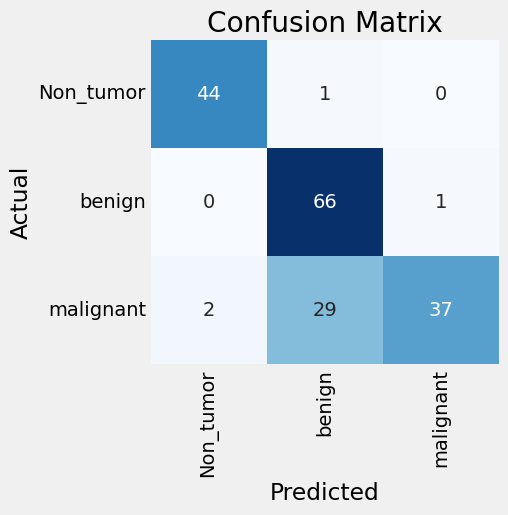

Classification Report:
----------------------
               precision    recall  f1-score   support

   Non_tumor       0.96      0.98      0.97        45
      benign       0.69      0.99      0.81        67
   malignant       0.97      0.54      0.70        68

    accuracy                           0.82       180
   macro avg       0.87      0.84      0.82       180
weighted avg       0.86      0.82      0.81       180



In [ ]:
results = model.evaluate(test_images, verbose=0)
#prediksi model
#argmax untuk mengmbil lokasi mana dengan probabilitas tertinggi atau indeks mana yg akan menjadi kelas
predictions = np.argmax(model.predict(test_images), axis=1)

#nama kelas berasal dari test images
class_names = list(test_images.class_indices.keys())

cm = confusion_matrix(test_images.labels, predictions, labels=np.arange(3))
clr = classification_report(test_images.labels, predictions, labels=np.arange(3), target_names=class_names)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
#fmt=g' ==> mencegah erhitungan klasifikasi muncul sebagai notasi ilmiah, menginginkan dalam bil.bulat
#vim=0 ==> nilai warna minimum 0
#cmap='Blues' ==> peta warna biru
#cbar=False ==> mematikan bilah warna
plt.xticks(ticks=np.arange(3) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(3) + 0.5, labels=class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [ ]:
model.save('/content/drive/My Drive/MobileNetV2_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



#Di dalam dataset

##Prediksi 1

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving HEALTHY_65_01.jpg to HEALTHY_65_01.jpg
HEALTHY_65_01.jpg


1/1 [==============================] - 1s 884ms/step


array([[9.9963641e-01, 1.5256173e-04, 2.1103430e-04]], dtype=float32)

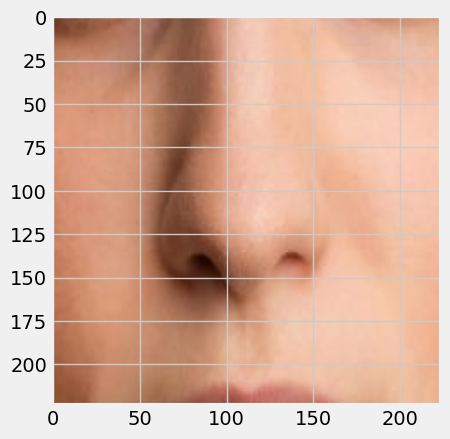

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 52ms/step


array([[9.9963641e-01, 1.5256173e-04, 2.1103430e-04]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[0, 2, 1]


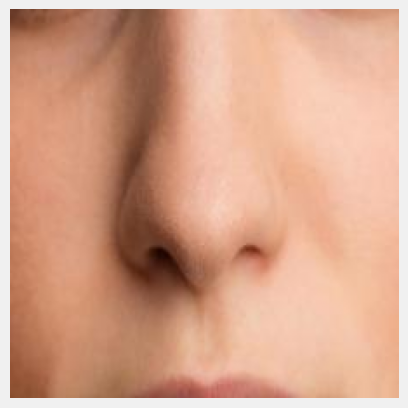

Non_tumor : 99.96 %
malignant : 0.02 %
benign : 0.02 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

##Prediksi 2

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

MessageError: RangeError: Maximum call stack size exceeded.

1/1 [==============================] - 0s 55ms/step


array([[1.7566181e-05, 2.4069455e-05, 9.9995840e-01]], dtype=float32)

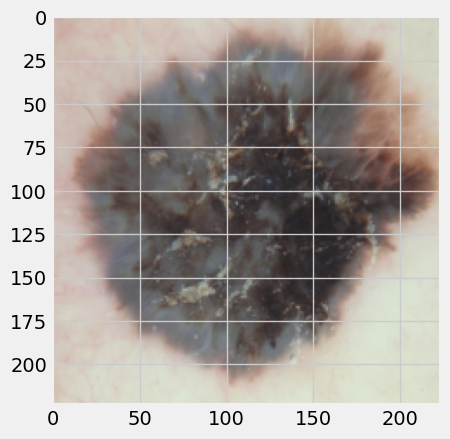

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 55ms/step


array([[1.7566181e-05, 2.4069455e-05, 9.9995840e-01]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[2, 1, 0]


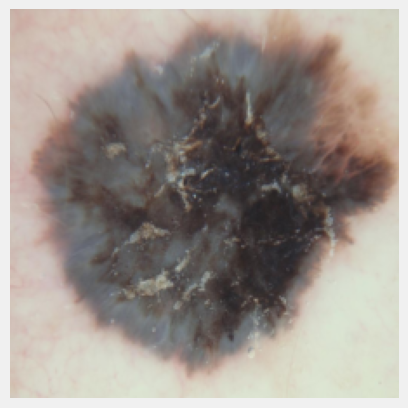

malignant : 100.0 %
benign : 0.0 %
Non_tumor : 0.0 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

##Prediksi 3

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving bopeng (9).jpg to bopeng (9).jpg
bopeng (9).jpg


1/1 [==============================] - 0s 135ms/step


array([[9.9999380e-01, 4.3006626e-06, 1.8479570e-06]], dtype=float32)

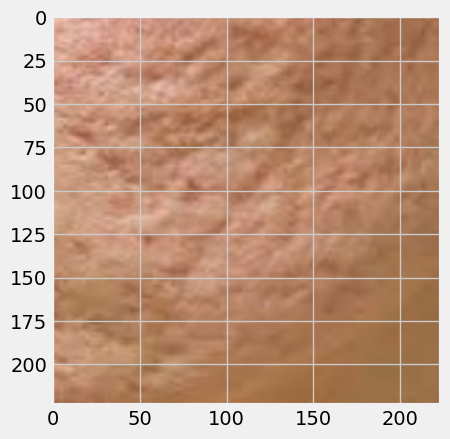

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 60ms/step


array([[9.9999380e-01, 4.3006626e-06, 1.8479570e-06]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[0, 1, 2]


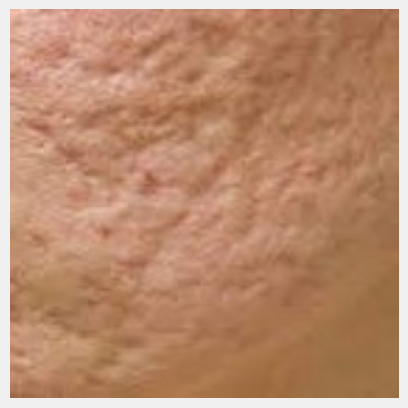

Non_tumor : 100.0 %
benign : 0.0 %
malignant : 0.0 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

##Prediksi 4

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving bruntusan (23).jpg to bruntusan (23).jpg
bruntusan (23).jpg


1/1 [==============================] - 0s 95ms/step


array([[9.99013066e-01, 8.81145475e-04, 1.05782085e-04]], dtype=float32)

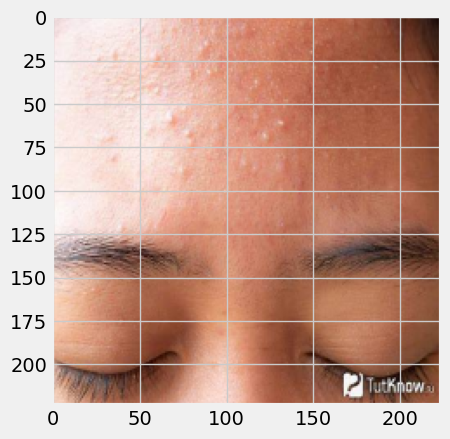

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 64ms/step


array([[9.99013066e-01, 8.81145475e-04, 1.05782085e-04]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[0, 1, 2]


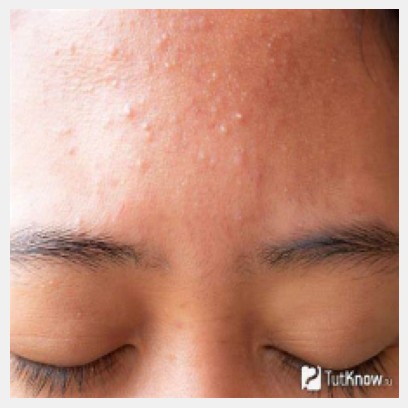

Non_tumor : 99.9 %
benign : 0.09 %
malignant : 0.01 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

##Prediksi 5

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving papula (33).jpg to papula (33).jpg
papula (33).jpg


1/1 [==============================] - 0s 54ms/step


array([[9.9992096e-01, 7.8124365e-05, 9.2802946e-07]], dtype=float32)

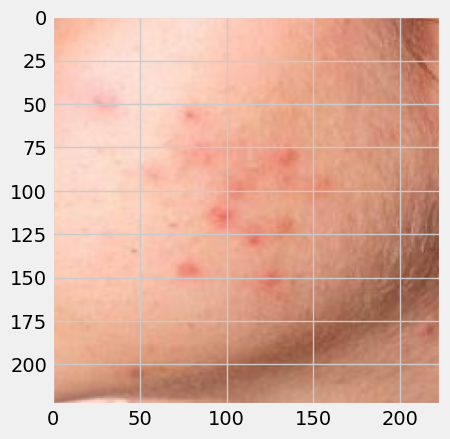

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 66ms/step


array([[9.9992096e-01, 7.8124365e-05, 9.2802946e-07]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[0, 1, 2]


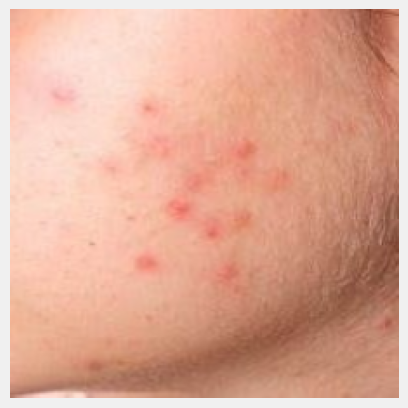

Non_tumor : 99.99 %
benign : 0.01 %
malignant : 0.0 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

##Prediksi 6

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving pustula (2).jpg to pustula (2) (1).jpg
pustula (2) (1).jpg


1/1 [==============================] - 0s 86ms/step


array([[0.9837114 , 0.01298014, 0.00330849]], dtype=float32)

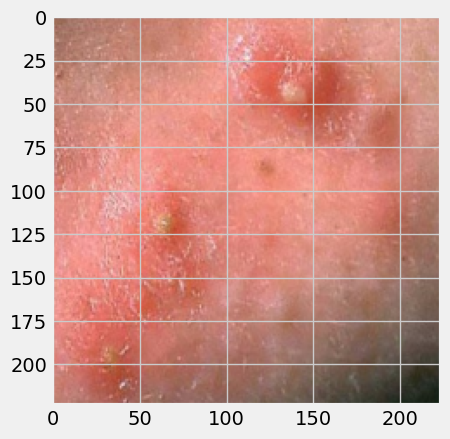

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 68ms/step


array([[0.9837114 , 0.01298014, 0.00330849]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[0, 1, 2]


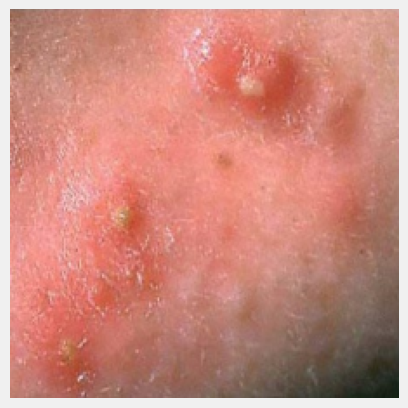

Non_tumor : 98.37 %
benign : 1.3 %
malignant : 0.33 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

##Prediksi 7

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving HEALTHY_60_01.jpg to HEALTHY_60_01.jpg
HEALTHY_60_01.jpg


1/1 [==============================] - 0s 105ms/step


array([[9.9990344e-01, 9.3894785e-05, 2.6361708e-06]], dtype=float32)

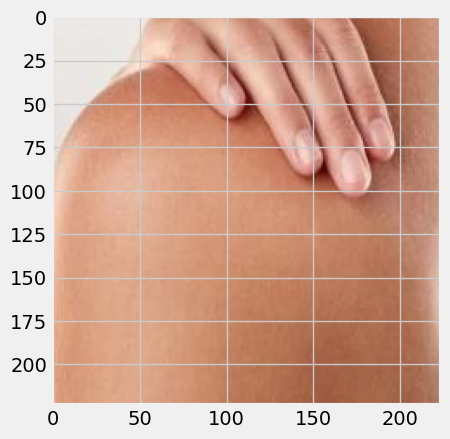

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 65ms/step


array([[9.9990344e-01, 9.3894785e-05, 2.6361708e-06]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[0, 1, 2]


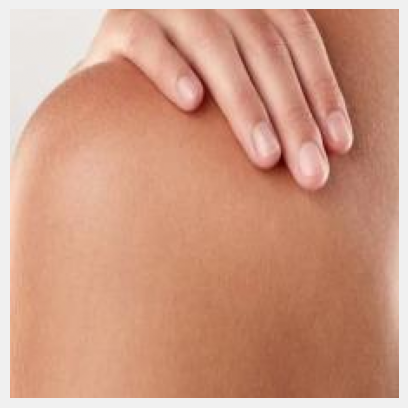

Non_tumor : 99.99 %
benign : 0.01 %
malignant : 0.0 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

#Di luar dataset

##Prediksi 1

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving 183.jpg to 183.jpg
183.jpg


1/1 [==============================] - 0s 67ms/step


array([[2.4853949e-04, 9.9677688e-01, 2.9745703e-03]], dtype=float32)

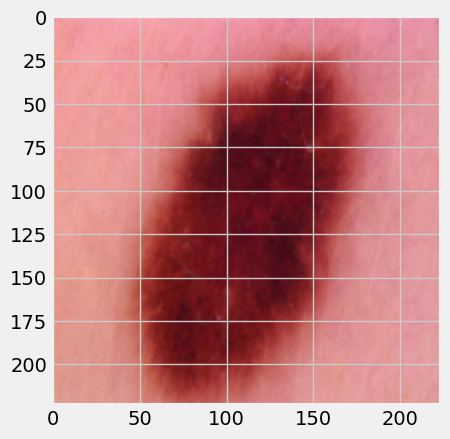

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 63ms/step


array([[2.4853949e-04, 9.9677688e-01, 2.9745703e-03]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[1, 2, 0]


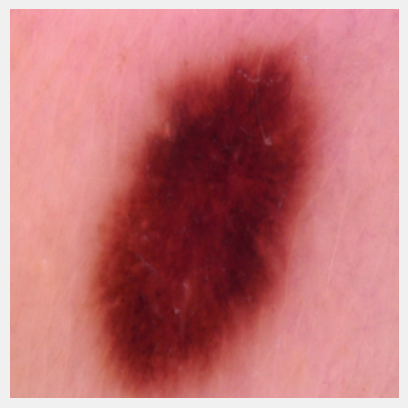

benign : 99.68 %
malignant : 0.3 %
Non_tumor : 0.02 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

##Prediksi 2

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving 190.jpg to 190.jpg
190.jpg


1/1 [==============================] - 0s 116ms/step


array([[0.00139774, 0.00411796, 0.99448425]], dtype=float32)

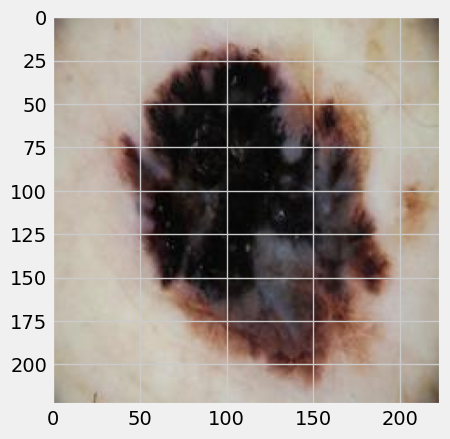

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 56ms/step


array([[0.00139774, 0.00411796, 0.99448425]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[2, 1, 0]


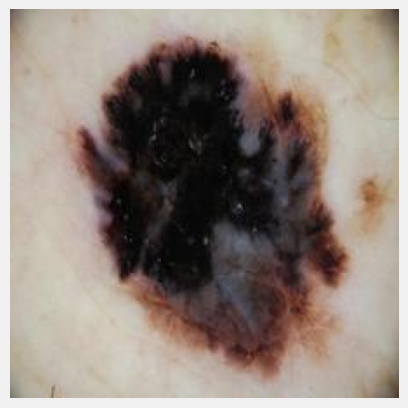

malignant : 99.45 %
benign : 0.41 %
Non_tumor : 0.14 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

##Prediksi 3

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving D07C6FAF-361A-4675-A4A8-D70203C19113.jpeg to D07C6FAF-361A-4675-A4A8-D70203C19113.jpeg
D07C6FAF-361A-4675-A4A8-D70203C19113.jpeg


1/1 [==============================] - 0s 68ms/step


array([[9.9999988e-01, 2.0283071e-10, 6.5401359e-08]], dtype=float32)

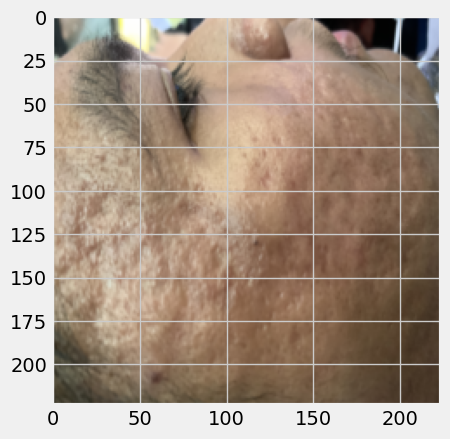

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 62ms/step


array([[9.9999988e-01, 2.0283071e-10, 6.5401359e-08]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[0, 2, 1]


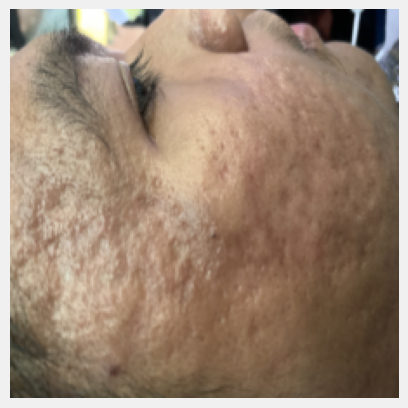

Non_tumor : 100.0 %
malignant : 0.0 %
benign : 0.0 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

##Prediksi 4

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving asd (5).jpg to asd (5).jpg
asd (5).jpg


1/1 [==============================] - 0s 68ms/step


array([[9.9859864e-01, 1.3838145e-03, 1.7516282e-05]], dtype=float32)

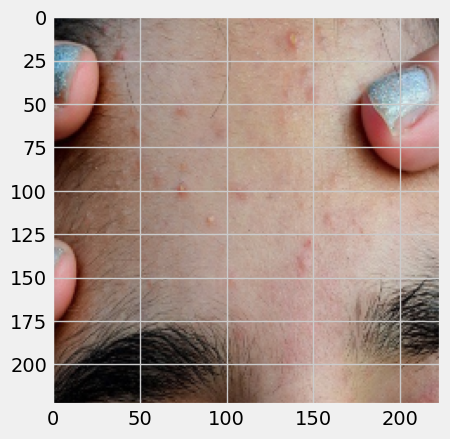

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 91ms/step


array([[9.9859864e-01, 1.3838145e-03, 1.7516282e-05]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[0, 1, 2]


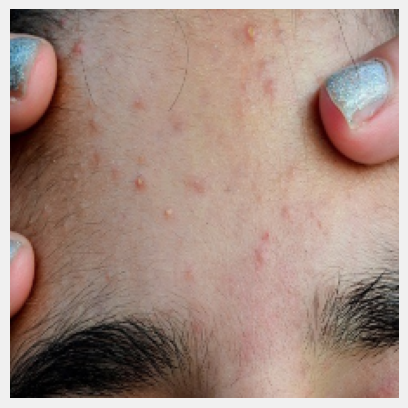

Non_tumor : 99.86 %
benign : 0.14 %
malignant : 0.0 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

##Prediksi 5

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving images (3).jpg to images (3).jpg
images (3).jpg


1/1 [==============================] - 0s 64ms/step


array([[9.9992204e-01, 7.2715695e-05, 5.2380119e-06]], dtype=float32)

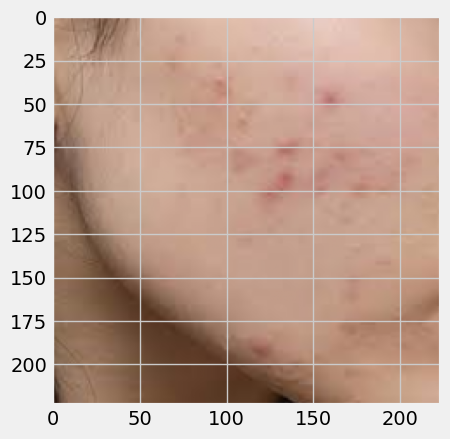

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 68ms/step


array([[9.9992204e-01, 7.2715695e-05, 5.2380119e-06]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[0, 1, 2]


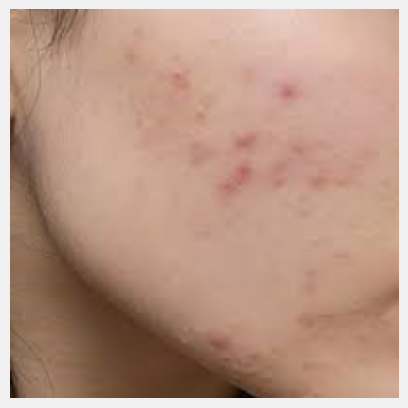

Non_tumor : 99.99 %
benign : 0.01 %
malignant : 0.0 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

##Prediksi 6

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving ilustrasi-jerawat-di-hidung_169.jpeg to ilustrasi-jerawat-di-hidung_169.jpeg
ilustrasi-jerawat-di-hidung_169.jpeg


1/1 [==============================] - 0s 65ms/step


array([[9.9089187e-01, 9.0297265e-03, 7.8454192e-05]], dtype=float32)

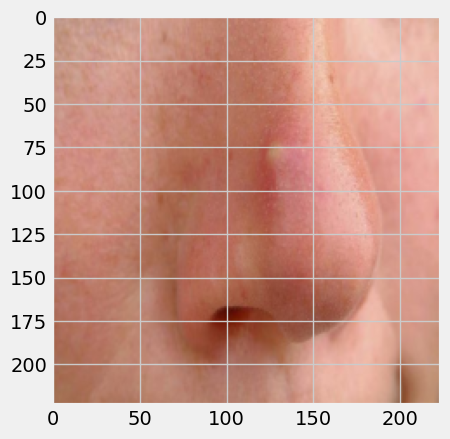

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 61ms/step


array([[9.9089187e-01, 9.0297265e-03, 7.8454192e-05]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[0, 1, 2]


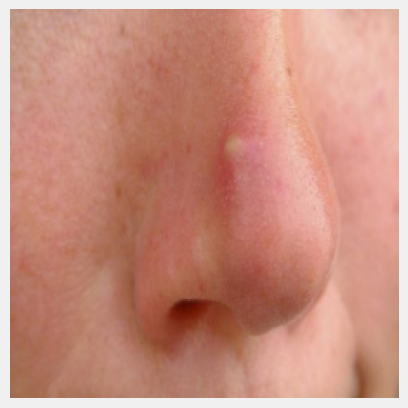

Non_tumor : 99.09 %
benign : 0.9 %
malignant : 0.01 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')

##Prediksi 7

In [ ]:
classification = ['Non_tumor','benign','malignant']

#Test the model with an example
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print(file_name)

Saving HEALTHY_90_01.jpg to HEALTHY_90_01.jpg
HEALTHY_90_01.jpg


1/1 [==============================] - 0s 63ms/step


array([[9.9989903e-01, 1.0730485e-05, 9.0257818e-05]], dtype=float32)

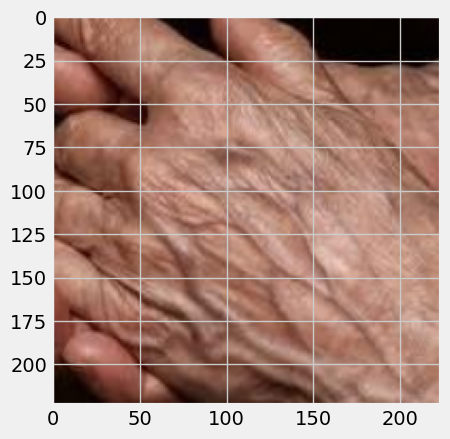

In [ ]:
#Resized the image
new_image = plt.imread(file_name)

from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

In [ ]:
#Model prediksi
predictions = model.predict(np.array([resized_image]))
predictions

1/1 [==============================] - 0s 71ms/step


array([[9.9989903e-01, 1.0730485e-05, 9.0257818e-05]], dtype=float32)

In [ ]:
#sort the predictions from least to greatest
list_index = [0,1,2]

x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels in order
print(list_index)

[0, 2, 1]


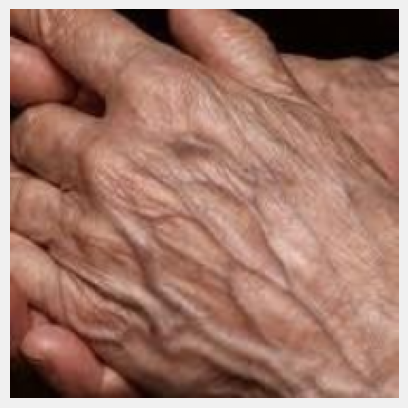

Non_tumor : 99.99 %
malignant : 0.01 %
benign : 0.0 %


In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.imshow(resized_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

#show img and print the predictions
for i in range(3):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]]*100,2),'%')